# Forecasting

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data
    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.
    Args:
        time (array of int) - contains the time steps
        slope (float) - determines the direction and steepness of the line
    Returns:
        series (array of float) - measurements that follow a straight line
    """
    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    Args:
        season_time (array of float) - contains the measurements per time step
    Returns:
        data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """
    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period
    Args:
        time (array of int) - contains the time steps
        period (int) - number of time steps before the pattern repeats
        amplitude (int) - peak measured value in a period
        phase (int) - number of time steps to shift the measured values
    Returns:
        data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal
    Args:
        time (array of int) - contains the time steps
        noise_level (float) - scaling factor for the generated signal
        seed (int) - number generator seed for repeatability
    Returns:
        noise (array of float) - the noisy signal
    """
    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate Data

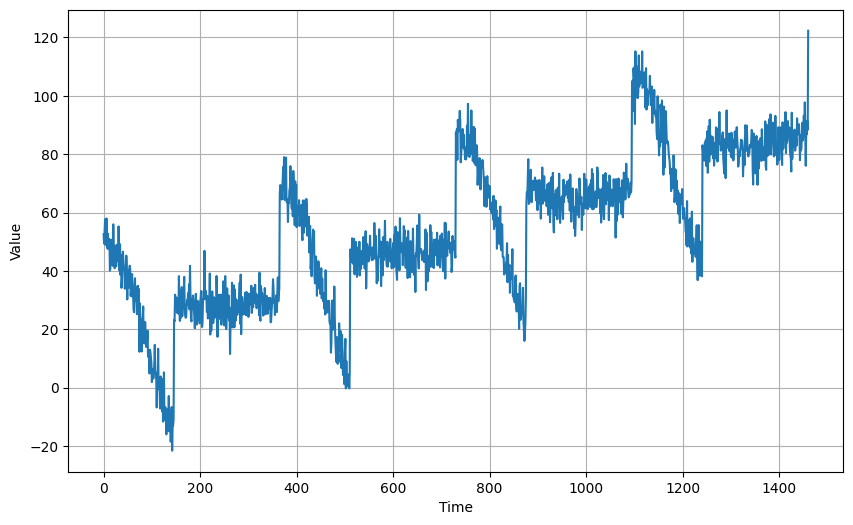

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
SPLIT_TIME = 1000

# Get the train set
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

# Get the validation set
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

## Prepare Features and Labels

In [5]:
# Parameters
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows
    Args:
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the feature
        batch_size (int) - the batch size
        shuffle_buffer(int) - buffer size to use for the shuffle method
    Returns:
        dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size, + 1 indicates that we're taking the next point as the label
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch, we need tensors instead of the Dataset structure for training.
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer) # return a batched dataset with that number of windows
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


## Model

 For time series data, it is good practice to not let computations for a particular time step to be affected by values into the future. The Conv1D deals with this issue by setting padding=causal.

In [10]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

In [11]:
# Get initial weights
init_weights = model.get_weights()

In [12]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 6s 63ms/step - loss: 284.7196 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 166.7698 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 34.1243 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 11.4500 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 18ms/step - loss: 10.6679 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 10.3566 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 18ms/step - loss: 10.0813 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 18ms/step - loss: 9.7635 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 9.4397 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 16ms/step - loss: 9.1104 - lr: 2.8184e-08
Epoch 11/1

(1e-08, 0.001, 0.0, 50.0)

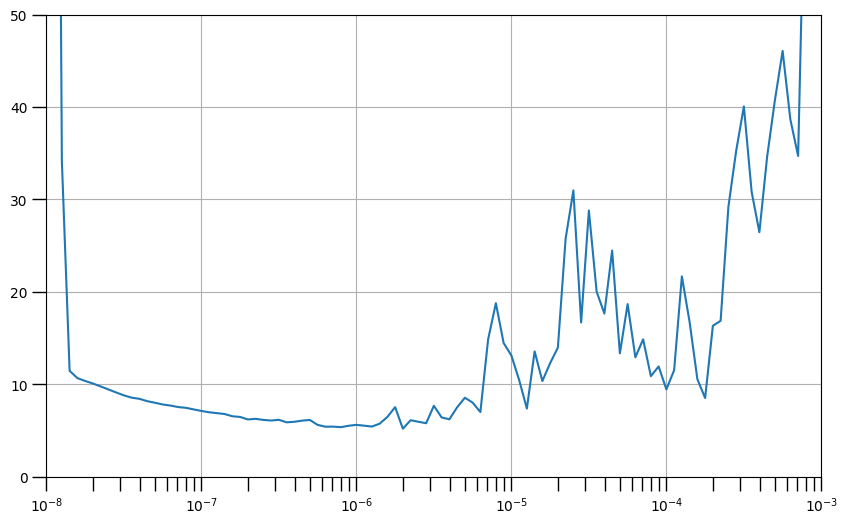

In [13]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the Model

In [31]:
val_set = windowed_dataset(x_valid, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [36]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        '''
        Halts the training when a certain metric is met
        Args:
            epoch (integer) - index of epoch (required but unused in the function definition below)
            logs (dict) - metric results from the training epoch
        '''
        # Check the validation set MAE
        if logs.get('val_mae') < 6:
            # Stop if threshold is met
            print("\nRequired val MAE is met so cancelling training!")
            self.model.stop_training = True
# Instantiate the class
callbacks = MyCallback()

In [ ]:
# Reset the weights
model.set_weights(init_weights)

In [37]:
# Set the learning rate
LEARNING_RATE = 1e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae","mse"])

# Train the model
history = model.fit(dataset, epochs=100, validation_data=val_set, callbacks=[callbacks])

Epoch 1/100
31/31 [==============================] - 6s 60ms/step - loss: 49.3849 - mae: 49.8839 - mse: 5993.6572 - val_loss: 50.3528 - val_mae: 50.8528 - val_mse: 2809.0205
Epoch 2/100
31/31 [==============================] - 1s 24ms/step - loss: 21.1705 - mae: 21.6636 - mse: 680.7181 - val_loss: 24.2252 - val_mae: 24.7230 - val_mse: 766.9710
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 13.8219 - mae: 14.3158 - mse: 303.2586 - val_loss: 15.9510 - val_mae: 16.4467 - val_mse: 377.6177
Epoch 4/100
31/31 [==============================] - 1s 20ms/step - loss: 11.8114 - mae: 12.3029 - mse: 220.8712 - val_loss: 7.8527 - val_mae: 8.3358 - val_mse: 115.0965
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 8.0489 - mae: 8.5341 - mse: 124.5609 - val_loss: 6.9352 - val_mae: 7.4153 - val_mse: 93.4128
Epoch 6/100
31/31 [==============================] - 1s 23ms/step - loss: 10.1714 - mae: 10.6652 - mse: 178.5507 - val_loss: 13.5048 - val_mae: 1

## Accuracy and Loss

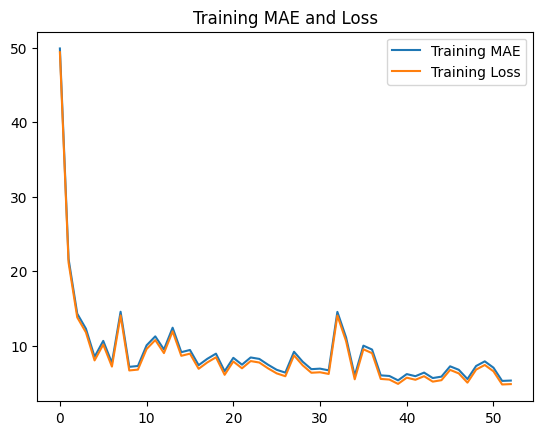

<Figure size 640x480 with 0 Axes>

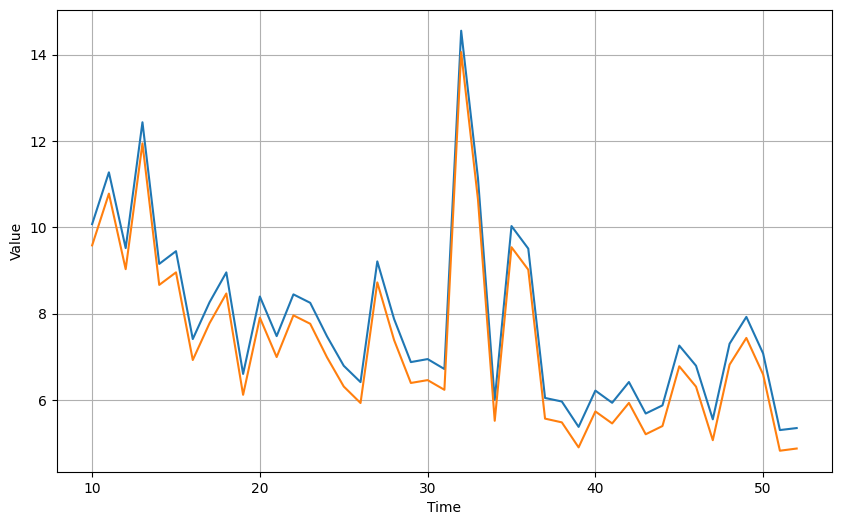

In [38]:
def plot_acc_val(history):
    mae = history.history['mae']
    mse = history.history['mse']
    loss = history.history['loss']
    epochs = range(len(mae)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, mae, label='Training MAE')
    plt.plot(epochs, loss, label='Training Loss')
    plt.title('Training MAE and Loss')
    plt.legend()
    plt.figure()

    # Only plot the last 80% of the epochs
    zoom_split = int(epochs[-1] * 0.2)
    epochs_zoom = epochs[zoom_split:]
    mae_zoom = mae[zoom_split:]
    loss_zoom = loss[zoom_split:]

    # Plot zoomed mae and loss
    plot_series(epochs_zoom, (mae_zoom, loss_zoom))

plot_acc_val(history)

## Model Prediction

In [39]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows
    Args:
        model (TF Keras Model) - model that accepts data windows
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the window
        batch_size (int) - the batch size
    Returns:
        forecast (numpy array) - array containing predictions
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 1s 7ms/step


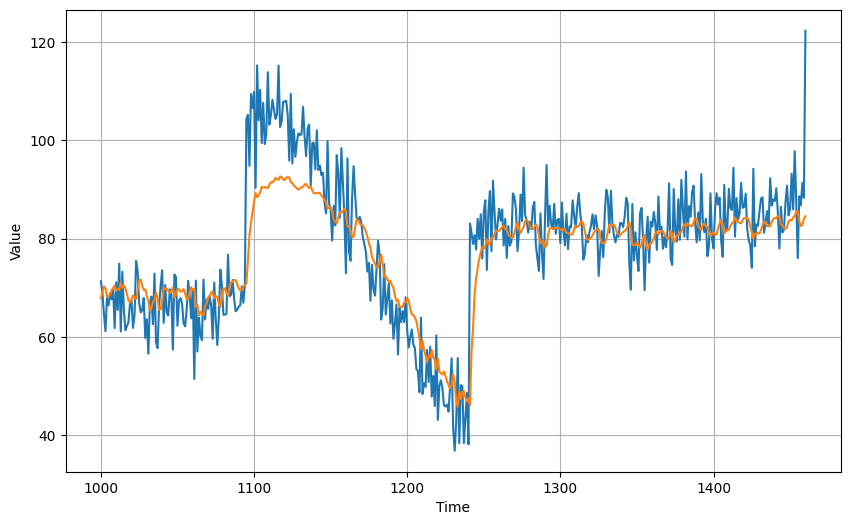

In [40]:
# Reduce the original series
forecast_series = series[SPLIT_TIME - WINDOW_SIZE: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [41]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

63.31478
5.86526
